# Group Modeling Notebook

## Created by: Kim Buesser, Griffin Brown, and Kathryn O'Connor

# Introduction

Home Credit is an international finance provider aiming to increase financial inclusion by providing financial loans to those with little to no credit history. Rather than rely on credit history, Home Credit uses a variety of data to assess an individual’s repayment abilities.

While they currently use a variety of statistical and machine learning methods to make their predictions, Home Credit is hoping to further harness their data to ensure that those who are capable of repaying loans are not rejected. Achieving greater accuracy on whether an individual is capable of loan repayment will not only allow Home Credit to broaden their customer base (and in turn, profit) they will also be able to help a larger population of individuals who are in need of loans.

In this notebook, different models are explored with the aim of developing a model that beats the majority class classifier and can be used to help solve their business problem.

Processes such cross-validation and feature engineering are used with different models to help optimize overall performance, and metrics will be used to compare to the majority class classifier.

## Our Philosophy

In our project journey, we adopted a collaborative mindset. We agreed that keeping our data manipulations and dataset usage consistent across all models would streamline our process and maintain coherence. This unified approach not only enhances efficiency but also cultivates a harmonious environment conducive to reaching our mutual goals.

## Package Import

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

## File Upload into Environment

Here, we stored our files in a Google Cloud Storage so we would not have to read directly from our local machines and change filepaths during development.

In [2]:
# Public URL after making the file public in the format 'https://storage.googleapis.com/...'
file_url = 'https://storage.googleapis.com/home_credit_files/application_train.csv'
test_url = 'https://storage.googleapis.com/home_credit_files/application_test.csv'
# POS_CASH_balance_url = 'https://storage.googleapis.com/home_credit_files/POS_CASH_balance.csv'
# bureau_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
# bureau_balance_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
# credit_card_balance = 'https://storage.googleapis.com/home_credit_files/credit_card_balance.csv'
# installments_payments = 'https://storage.googleapis.com/home_credit_files/credit_card_balance.csv'
# previous_application = 'https://storage.googleapis.com/home_credit_files/previous_application.csv'
sample_sub = 'https://storage.googleapis.com/home_credit_files/sample_submission.csv'


# Read the CSV directly from the URL
df = pd.read_csv(file_url)
test_df = pd.read_csv(test_url)

#print(df.head())

C:\Users\Owner\AppData\Local\Temp\ipykernel_65332\3497087744.py:14: DtypeWarning: Columns (90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_url)


# EDA
Below, we perform EDA on the train data set to prepare it for modeling. We began by analyzing the initial data set and obtaining the proportion of the target variable in the train set. About 92% of the data is 0, indicating those that repayed their loans on time. About 8% represent 1, those that did not repay on time.

Next, we explored missing variables. We calculated the percentage of missing values per column, and after analyzing the descriptions for each, decided to remove those that were missing greater than 10% of their values.

In [3]:
print(df.shape)

(307511, 122)


In [4]:
df['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [5]:
df['TARGET'].value_counts(normalize = True) * 100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

# Data Preparation

### Evaluating Missingness

In [6]:
# Train data set

# calculate total number of missing values for each column
missing_values_train = df.isnull().sum()

# calculate total number of rows
total_rows_train = df.shape[0]

# calculate percentage of missing values for each column
pct_missing_train = (missing_values_train / total_rows_train) * 100

# sort output
pct_missing_sorted_train = pct_missing_train.sort_values(ascending=False)

In [7]:
missings = pct_missing_sorted_train.to_frame(name='MissingPercentage')

### Removing columns with greater than 10% missing values

In [8]:
filter_missings = missings[(missings['MissingPercentage'] < 10)]
filter_missings.shape

(65, 1)

### Removing 'FLAG' columns and ID column

In [9]:
columns = list(filter_missings.index)
column_list = [item for item in columns if 'FLAG' not in item]

### Removing additional unhelpful columns

In [10]:
list1 = column_list
list2 = ['NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']

# Initialize an empty list to store items from list1 that are not in list2
items_not_in_list2 = []

# Iterate through each item in list1
for item in list1:
    # Check if the item is not in list2
    if item not in list2:
        # Add the item to the items_not_in_list2 list
        items_not_in_list2.append(item)


In [11]:
len(items_not_in_list2)

32

In [12]:
pd.set_option('display.max_columns', None)
selected_df = df[items_not_in_list2]
selected_df

test_filtered_columns = [item for item in items_not_in_list2 if item != 'TARGET']
test_selected_df = test_df[test_filtered_columns]

In [13]:
# Extract the 'TARGET' column
target = selected_df['TARGET']

# Remove the 'TARGET' column from the dataframe and reassign the result back to selected_df
selected_df = selected_df.drop(columns=['TARGET'])

# Insert the 'TARGET' column at the beginning of the dataframe
selected_df.insert(0, 'TARGET', target)

### Fix problematic values

In [14]:
selected_df.loc[:, 'DAYS_EMPLOYED'] = selected_df['DAYS_EMPLOYED'].replace(365243, 0)
selected_df = selected_df[selected_df['AMT_INCOME_TOTAL'] <= 9000000]

test_selected_df.loc[:, 'DAYS_EMPLOYED'] = test_selected_df['DAYS_EMPLOYED'].replace(365243, 0)
test_selected_df = test_selected_df[test_selected_df['AMT_INCOME_TOTAL'] <= 9000000]

In [15]:
print(selected_df.shape)
print(test_selected_df.shape)

(307508, 32)
(48744, 31)


test_selected_df should have one less column, TARGET, which is reflected.

In [16]:
selected_df = selected_df.drop(columns = ['HOUR_APPR_PROCESS_START', 'DAYS_ID_PUBLISH'])
test_selected_df = test_selected_df.drop(columns = ['HOUR_APPR_PROCESS_START', 'DAYS_ID_PUBLISH'])

In [17]:
set(test_selected_df)-set(selected_df)

set()

In [18]:
# Abs value of negatives
selected_df['DAYS_LAST_PHONE_CHANGE'] = selected_df.loc[:, 'DAYS_LAST_PHONE_CHANGE'].abs()
selected_df['DAYS_REGISTRATION'] = selected_df.loc[:, 'DAYS_REGISTRATION'].abs()
selected_df['DAYS_EMPLOYED'] = selected_df.loc[:, 'DAYS_EMPLOYED'].abs()
selected_df['DAYS_BIRTH'] = selected_df.loc[:, 'DAYS_BIRTH'].abs()

test_selected_df['DAYS_LAST_PHONE_CHANGE'] = test_selected_df.loc[:, 'DAYS_LAST_PHONE_CHANGE'].abs()
test_selected_df['DAYS_REGISTRATION'] = test_selected_df.loc[:, 'DAYS_REGISTRATION'].abs()
test_selected_df['DAYS_EMPLOYED'] = test_selected_df.loc[:, 'DAYS_EMPLOYED'].abs()
test_selected_df['DAYS_BIRTH'] = test_selected_df.loc[:, 'DAYS_BIRTH'].abs()

## Data Preparation Summary

Our initial approach was fairly simplistic for our first attempt. We started by dropped columns that had too much missing data with a cutoff of 10%. We then cut out all 'FLAG' columns as we thought these weren't needed for our basic approach. We fixed a couple columns that had some bad information, and all the while we did the same manipulations to the test set as we did with the train set. 

## Preparing Logistic Regression

In [19]:
# Grab numeric columns
numeric_cols = selected_df.drop(['SK_ID_CURR'], axis=1).select_dtypes(include='number')
numeric_cols

test_numeric_cols = test_selected_df.drop(['SK_ID_CURR'], axis=1).select_dtypes(include='number')
test_numeric_cols

,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,AMT_CREDIT,AMT_INCOME_TOTAL,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE
0,0.789654,450000.0,20560.5,2.0,1740.0,0,568800.0,135000.0,0,0,0,0,0,0,2,2,5170.0,2329,19241,0.018850
1,0.291656,180000.0,17370.0,2.0,0.0,0,222768.0,99000.0,0,0,0,0,0,0,2,2,9118.0,4469,18064,0.035792
2,0.699787,630000.0,69777.0,2.0,856.0,0,663264.0,202500.0,0,0,0,0,0,0,2,2,2175.0,4458,20038,0.019101
3,0.509677,1575000.0,49018.5,4.0,1805.0,2,1575000.0,315000.0,0,0,0,0,0,0,2,2,2000.0,1866,13976,0.026392
4,0.425687,625500.0,32067.0,3.0,821.0,1,625500.0,180000.0,1,1,0,0,0,0,2,2,4000.0,2191,13040,0.010032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.648575,270000.0,17473.5,1.0,684.0,0,412560.0,121500.0,0,0,0,0,0,0,3,3,9094.0,5169,19970,0.002042
48740,0.684596,495000.0,31909.5,4.0,0.0,2,622413.0,157500.0,1,1,0,0,0,0,2,2,3015.0,1149,11186,0.035792
48741,0.632770,315000.0,33205.5,3.0,838.0,1,315000.0,202500.0,0,0,0,0,0,0,2,2,2681.0,3037,15922,0.026392
48742,0.445701,450000.0,25128.0,2.0,2308.0,0,450000.0,225000.0,1,1,0,1,1,0,2,2,1461.0,2731,13968,0.018850


In [20]:
# Create a list of numeric column names excluding target for imputations

column_names = numeric_cols.columns.tolist()
my_list = [x for x in column_names if x != 'TARGET']
print(my_list)

test_column_names = numeric_cols.columns.tolist()
test_my_list = [x for x in column_names if x != 'TARGET']
print(test_my_list)

['EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE']
['EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE']


### N/a Imputer

In [21]:
# Create a SimpleImputer instance
imputer = SimpleImputer(strategy='median')

# Fit and transform the selected numeric columns
selected_df.loc[:, my_list] = imputer.fit_transform(selected_df.loc[:, my_list])

test_selected_df.loc[:, test_my_list] = imputer.fit_transform(test_selected_df.loc[:, test_my_list])

## Interaction Term

In [22]:
selected_df['CREDIT_TO_INCOME'] = selected_df['AMT_CREDIT']/selected_df['AMT_INCOME_TOTAL']

test_selected_df['CREDIT_TO_INCOME'] = test_selected_df['AMT_CREDIT']/test_selected_df['AMT_INCOME_TOTAL']

### Standard Scaler to scale dataset

In [23]:
#scalar_list = ['EXT_SOURCE_2','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_CREDIT','AMT_INCOME_TOTAL','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','CREDIT_TO_INCOME']

In [24]:
scaler = StandardScaler()

# Fit and transform the selected columns
selected_df[my_list] = scaler.fit_transform(selected_df[my_list])

test_selected_df[test_my_list] = scaler.fit_transform(test_selected_df[test_my_list])

print(selected_df.shape)
print(test_selected_df.shape)

(307508, 31)
(48744, 30)


### Dummy Encoder 

In [25]:
# dummy encoding data set

selected_df = pd.get_dummies(selected_df, drop_first=True)

test_selected_df = pd.get_dummies(test_selected_df, drop_first=True)

print(selected_df.shape)
print(test_selected_df.shape)

print(set(test_selected_df)-set(selected_df))
print(set(selected_df)-set(test_selected_df))

columns_to_drop = set(selected_df.columns) - set(test_selected_df.columns)
columns_to_drop.discard('TARGET')
selected_df = selected_df.drop(columns=list(columns_to_drop), axis=1)

print(selected_df.shape)
print(test_selected_df.shape)

(307508, 110)
(48744, 106)
set()
{'TARGET', 'NAME_FAMILY_STATUS_Unknown', 'CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave'}
(307508, 107)
(48744, 106)


### Splitting Target and Predictors

In [26]:
X = selected_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = selected_df['TARGET']

## Upsampling

We created an upsampled fold of data to test how this effected each of our models.

In [27]:
X = selected_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = selected_df['TARGET']

data = pd.concat([X, y], axis=1)

# Separate majority and minority classes
majority = data[data.TARGET==0]
minority = data[data.TARGET==1]

# Upsample minority class
minority_upsampled = resample(minority, 
                              replace=True,     # sample with replacement
                              n_samples=len(majority),    # to match majority class size
                              random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([majority, minority_upsampled])

# Checking the new class distribution
upsampled_data.TARGET.value_counts()

X_upsampled = upsampled_data.drop('TARGET', axis=1)
y_upsampled = upsampled_data['TARGET']


# Modeling

We chose to create three main models, Log Regression, XGBoost and Random Forest. Each one was tweaked several times to find the best fit. Overfitting of the tree models was a common occurence. Typically, trees with less depth fit a better model.

## Logistic Regression 

In [28]:
# Initializing and training the logistic regression model
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X, y)

# Making predictions on the validation set
y_pred = log_reg.predict(X)

# Calculating the accuracy of the model
accuracy = accuracy_score(y, y_pred)
print("Train Accuracy:", accuracy)
print("Train R2 = ", log_reg.score(X, y))

Train Accuracy: 0.9192703929653863
Train R2 =  0.9192703929653863


In [29]:
# Predict probabilities for the positive class (class 1) using the trained model
y_prob = log_reg.predict_proba(X)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Calculate AUC score
auc_score = auc(fpr, tpr)
print("AUC Score (Original):", auc_score)

AUC Score (Original): 0.7023817511565043


## Logistic Regression Upsampled

In [30]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Upsample the dataset
X_upsampled, y_upsampled = smote.fit_resample(X_upsampled, y_upsampled)

# Initialize and train the logistic regression model with the upsampled dataset
log_reg_upsampled = LogisticRegression(max_iter=2000)
log_reg_upsampled.fit(X_upsampled, y_upsampled)

# Make predictions on the upsampled dataset
y_pred_upsampled = log_reg_upsampled.predict(X_upsampled)

# Calculate accuracy on the upsampled dataset
accuracy_upsampled = accuracy_score(y_upsampled, y_pred_upsampled)
print("Train Accuracy (Upsampled):", accuracy_upsampled)
print("Train R2 (Upsampled):", log_reg_upsampled.score(X_upsampled, y_upsampled))

Train Accuracy (Upsampled): 0.6465523340549872
Train R2 (Upsampled): 0.6465523340549872


In [31]:
# Predict probabilities for the positive class (class 1) using upsampled model
y_prob_upsampled = log_reg_upsampled.predict_proba(X_upsampled)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds for upsampled model
fpr_upsampled, tpr_upsampled, thresholds_upsampled = roc_curve(y_upsampled, y_prob_upsampled)

# Calculate AUC score for upsampled model
auc_score_upsampled = auc(fpr_upsampled, tpr_upsampled)
print("AUC Score (Upsampled):", auc_score_upsampled)

AUC Score (Upsampled): 0.7029145209995815


### Cross Validation Function

We used a cross validation technique of 10 folds on each data set to test the performance of each model.

### Mean Squared Error - simple logistic model

In [32]:


# Call the function  and define a scoring function - set it as "neg_mean_squared_error"
log_scores = cross_val_score(log_reg, 
                             X, 
                             y,
                             scoring="neg_mean_squared_error",   # higher return values are better for this function
                             cv=10                               # create 10 folds
)

# to obtain RMSE, we need to negate the scores obtained  from cross_val_score and take the sqrt.
# this returns an array of 10 values
log_rmse_scores = np.sqrt(-log_scores)


In [33]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [34]:
display_scores(log_rmse_scores)

Scores: [0.28415725 0.28398553 0.28410002 0.28410002 0.28421446 0.28421446
 0.28410002 0.28415725 0.28410464 0.28410464]
Mean: 0.28412383038612216
Standard deviation: 6.342295657662918e-05


### Mean Squared Error - upsampled logistic model

In [35]:
log_scores_upsampled = cross_val_score(log_reg_upsampled, 
                                       X_upsampled, 
                                       y_upsampled,
                                       scoring="neg_mean_squared_error",   # higher return values are better for this function
                                       cv=10 # create 10 folds
)

log_rmse_scores_upsampled = np.sqrt(-log_scores_upsampled)

In [36]:
display_scores(log_rmse_scores_upsampled)

Scores: [0.62525796 0.62109989 0.62101445 0.62001679 0.60558508 0.58570443
 0.56492136 0.56869722 0.57693142 0.58129905]
Mean: 0.5970527661509181
Standard deviation: 0.022729724535834384


### R Squared - simple logistic model

In [37]:
log_r2_scores = cross_val_score(log_reg, 
                             X, y,
                             scoring="r2", 
                             cv=10)
display_scores(log_r2_scores)

Scores: [-0.08823763 -0.08692281 -0.08779936 -0.08779936 -0.08827595 -0.08827595
 -0.08739972 -0.08783784 -0.08780246 -0.08780246]
Mean: -0.08781535393759046
Standard deviation: 0.00039665612854916947


In [38]:
log_auc_scores = cross_val_score(log_reg, 
                             X, 
                             y,
                             scoring="roc_auc", 
                             cv=10                               
)
log_mean_auc = np.mean(log_auc_scores)
display_scores(log_auc_scores)

Scores: [0.6903184  0.70347096 0.70158538 0.70195599 0.69615938 0.74887839
 0.70074192 0.67980056 0.69521011 0.69968139]
Mean: 0.7017802488408945
Standard deviation: 0.01707597037971625


### R squared - upsampled logistic model

In [39]:
log_up_r2_scores = cross_val_score(log_reg_upsampled, 
                             X_upsampled, 
                             y_upsampled,
                             scoring="r2", 
                             cv=10)
display_scores(log_up_r2_scores)

Scores: [-0.56379008 -0.5430603  -0.5426358  -0.53768329 -0.46693316 -0.37219874
 -0.27654456 -0.2936661  -0.33139946 -0.35163436]
Mean: -0.4279545841465465
Standard deviation: 0.10845592749756727


In [40]:
log_up_auc_scores = cross_val_score(log_reg_upsampled, 
                             X_upsampled, 
                             y_upsampled,
                             scoring="roc_auc", 
                             cv=10                               
)
log_up_mean_auc = np.mean(log_up_auc_scores)
display_scores(log_up_auc_scores)

Scores: [0.65557391 0.66100495 0.65878314 0.66380426 0.68576933 0.71716312
 0.74759937 0.74110905 0.72937042 0.72296772]
Mean: 0.6983145263525156
Standard deviation: 0.035096611096565956


## XGBoost

In [41]:

xgb_clf = XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss', 
                        n_estimators=100, 
                        max_depth=6
                        )

xgb_clf.fit(X, y)

xgb_y_pred = xgb_clf.predict(X)

xgb_accuracy = accuracy_score(y, xgb_y_pred)

print("Train Accuracy:", xgb_accuracy)
print("Train Accuracy using built-in score:", xgb_clf.score(X, y))

Train Accuracy: 0.9206524708300272
Train Accuracy using built-in score: 0.9206524708300272


In [42]:
xgb_auc_scores = cross_val_score(xgb_clf, 
                             X, 
                             y,
                             scoring="roc_auc", 
                             cv=10                               
)
xgb_mean_auc = np.mean(xgb_auc_scores)
display_scores(xgb_auc_scores)

Scores: [0.69330658 0.71401356 0.7128278  0.70951738 0.71151834 0.73842159
 0.70941967 0.6931171  0.7098679  0.70629247]
Mean: 0.7098302392470597
Standard deviation: 0.011882527526662214


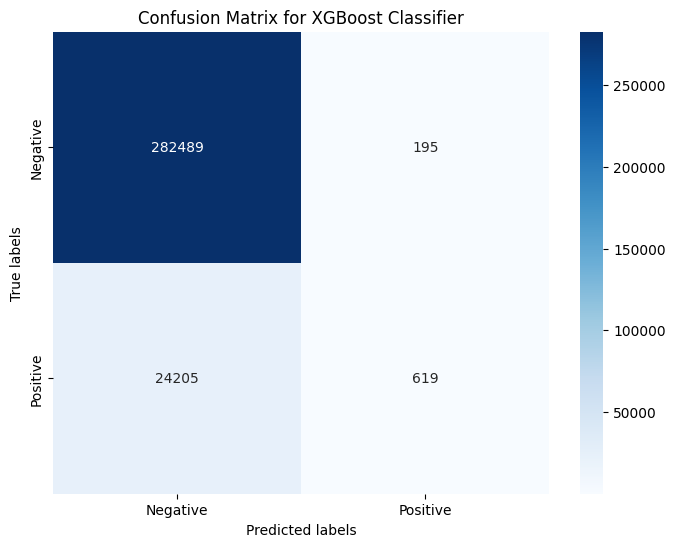

In [43]:
xgb_cm = confusion_matrix(y, xgb_y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()


## XGBoost Upsample

In [44]:
xgb_clf_upsampled = XGBClassifier(use_label_encoder=False, 
                                  eval_metric='logloss', 
                                  n_estimators=100, 
                                  max_depth=6)

# Train the model on the upsampled dataset
xgb_clf_upsampled.fit(X_upsampled, y_upsampled)

# Make predictions (as an example, using the same upsampled data for simplicity)
y_pred_upsampled = xgb_clf_upsampled.predict(X_upsampled)

# Calculate accuracy
accuracy_upsampled = accuracy_score(y_upsampled, y_pred_upsampled)
print("Train Accuracy on Upsampled Data:", accuracy_upsampled)

Train Accuracy on Upsampled Data: 0.7331967851028003


## Random Forest

In [45]:
rf_clf = RandomForestClassifier(n_estimators=100, 
                                max_depth=4, 
                                random_state=42)

rf_clf.fit(X, y)

rf_y_pred = rf_clf.predict(X)

accuracy = accuracy_score(y, rf_y_pred)
print("Train Accuracy:", accuracy)
print("Train Accuracy using built-in score:", rf_clf.score(X, y))

Train Accuracy: 0.9192736449133031
Train Accuracy using built-in score: 0.9192736449133031


In [46]:
rf_auc_scores = cross_val_score(rf_clf, 
                             X, 
                             y,
                             scoring="roc_auc", 
                             cv=10                               
)
rf_mean_auc = np.mean(rf_auc_scores)
display_scores(rf_auc_scores)

Scores: [0.6756946  0.69538411 0.68960184 0.69260569 0.68627586 0.73637199
 0.68917033 0.66824685 0.67617959 0.68340059]
Mean: 0.6892931447802181
Standard deviation: 0.01763025579980236


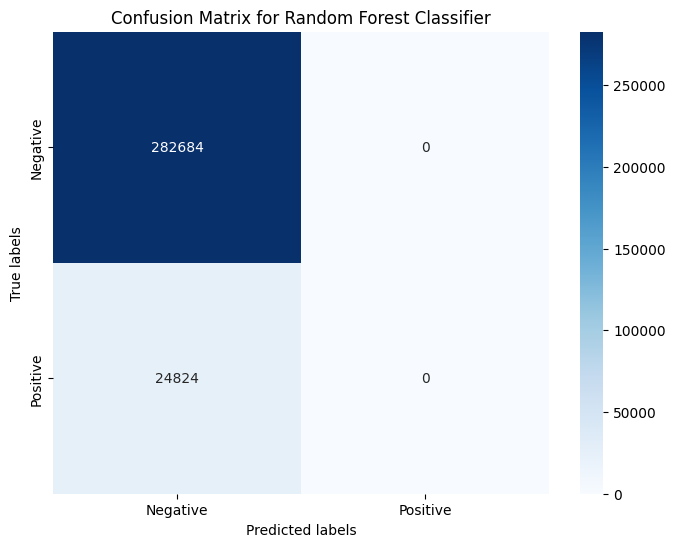

In [47]:
rf_cm = confusion_matrix(y, rf_y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

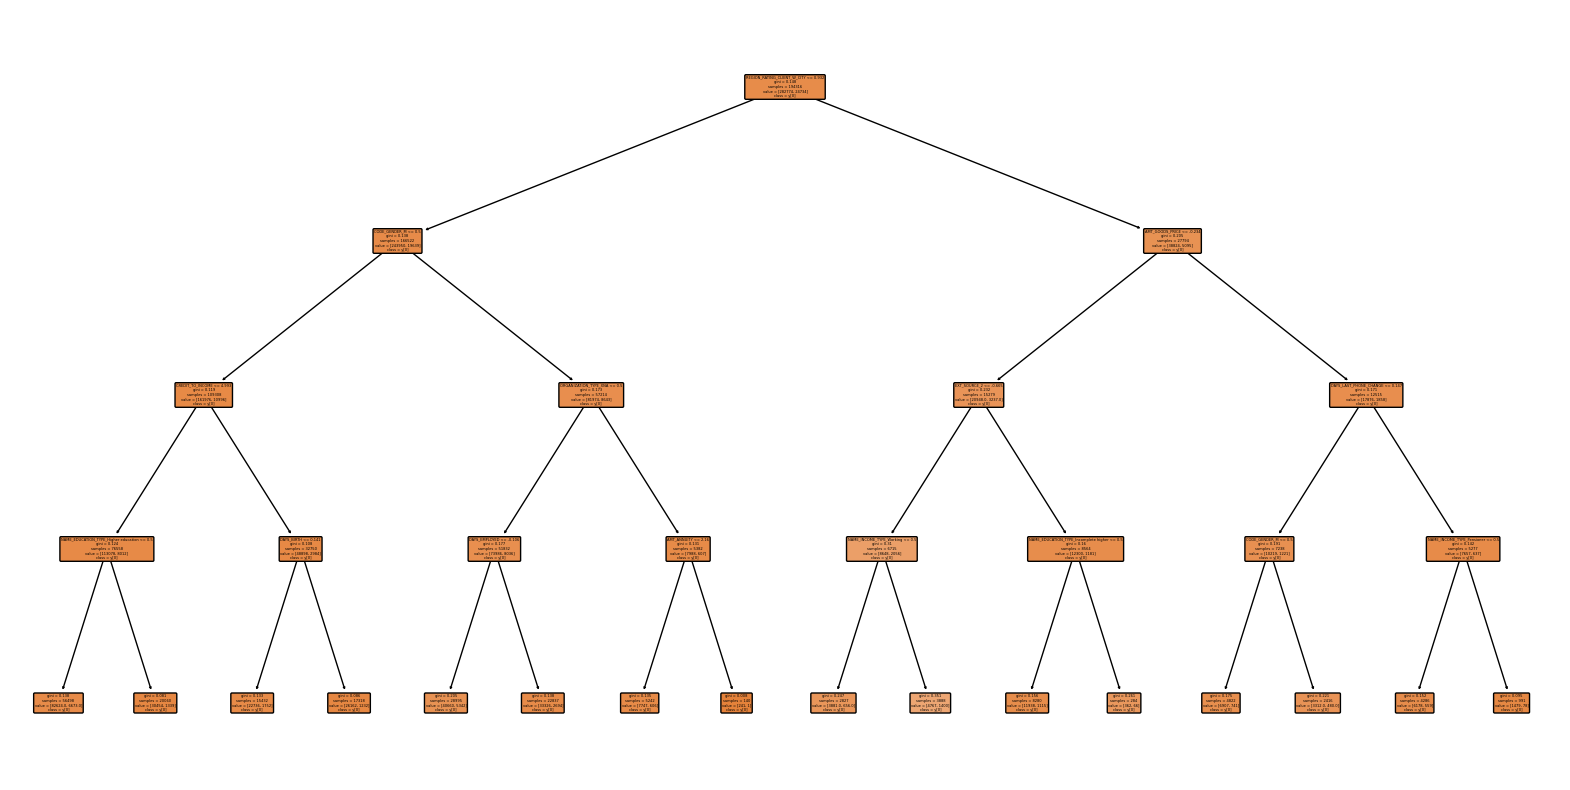

In [48]:
single_tree = rf_clf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()

This was not a great model, since it predicted the majority class everytime. We should dive back into our predictors to see what we can do better.

## Random Forest Upsampled

In [49]:
rf_clf_upsampled = RandomForestClassifier(n_estimators=100, 
                                          max_depth=4, 
                                          random_state=42)

rf_clf_upsampled.fit(X_upsampled, y_upsampled)

# Making predictions on the upsampled training set for demonstration
rf_y_pred_upsampled = rf_clf_upsampled.predict(X_upsampled)

# Calculate accuracy
accuracy_upsampled = accuracy_score(y_upsampled, rf_y_pred_upsampled)
print("Train Accuracy on Upsampled Data:", accuracy_upsampled)

Train Accuracy on Upsampled Data: 0.6404412701107951


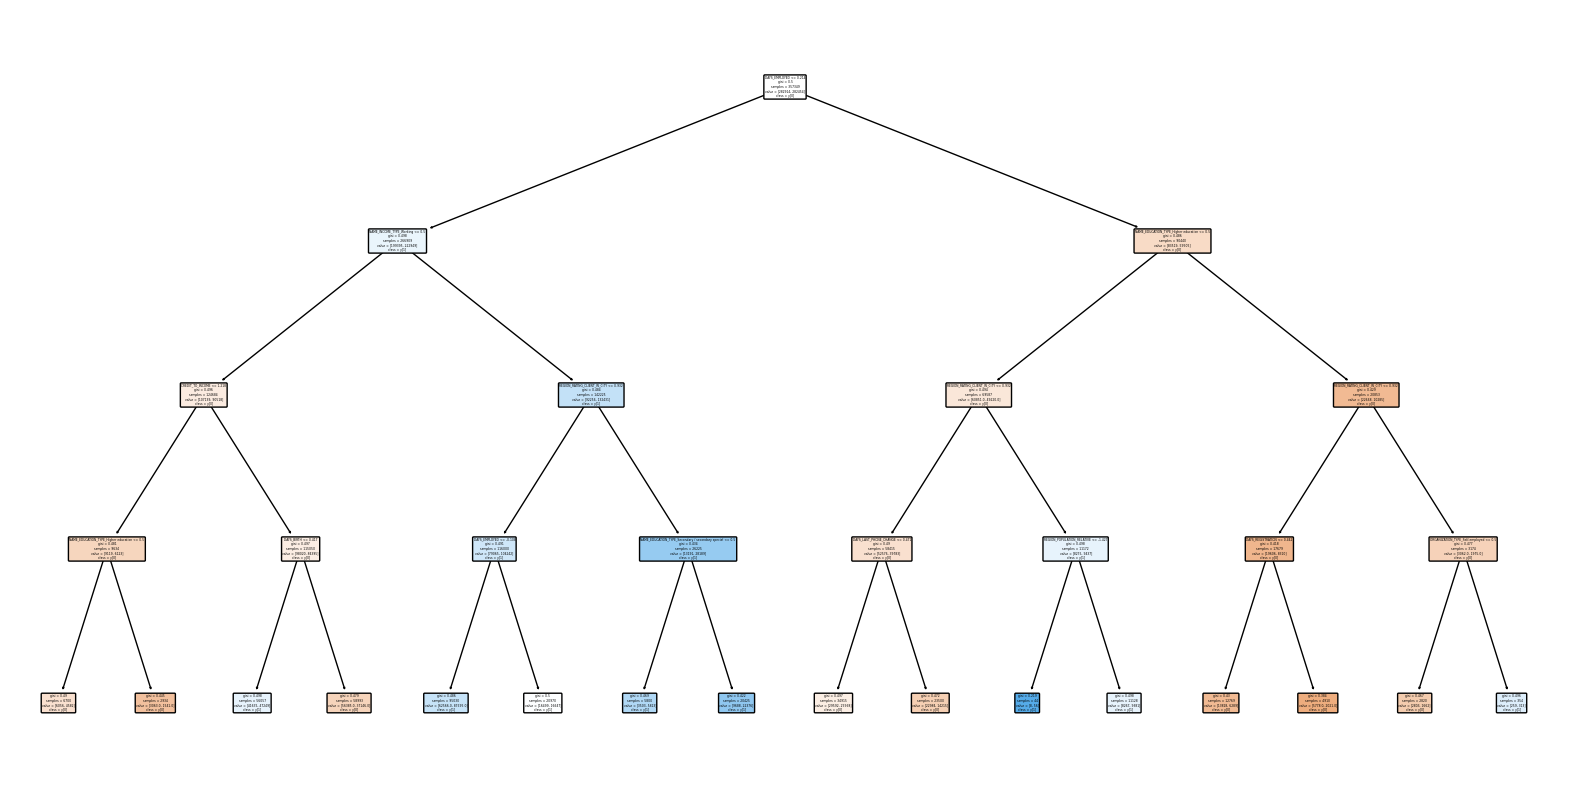

In [50]:
single_tree = rf_clf_upsampled.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()

The upsampling gave a bit more diversity to the tree.

# Test Evaluation

In [51]:
# Step 1: Assuming 'test_df' contains 'SK_ID_CURR' and you're about to predict
# Save the IDs in a separate variable or ensure they're in 'test_df'
ids = test_selected_df['SK_ID_CURR'].copy()

# If you had to remove 'SK_ID_CURR' from test_df for prediction, do so
test_features = test_selected_df.drop(columns=['SK_ID_CURR'])

# Step 2: Predict TARGET on the test set
xgb_y_test_pred = xgb_clf_upsampled.predict(test_features)

# Step 3: Combine IDs with their corresponding predictions
predictions_with_ids = pd.DataFrame({'SK_ID_CURR': ids, 'TARGET': xgb_y_test_pred})

print(predictions_with_ids['TARGET'].value_counts())

# Now you can see the dataset with IDs and the new TARGET column
print(predictions_with_ids.head())
sample = pd.read_csv(sample_sub)
print(sample.head())


TARGET
0    33833
1    14911
Name: count, dtype: int64
   SK_ID_CURR  TARGET
0      100001       0
1      100005       1
2      100013       0
3      100028       0
4      100038       0
   SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5


In [52]:
directory = 'C:\\Users\\Owner\\OneDrive\\Documents'
filename = 'predictions_with_ids.csv'
path = os.path.join(directory, filename)

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Now it's safe to write the file
predictions_with_ids.to_csv(path, index=False)

## Results

During our exploratory data analysis (EDA) and initial model building, we identified two key challenges: the imbalanced distribution of the target variable and the presence of a substantial number of missing values. Addressing these challenges was crucial for enhancing our model performance.

Upsampling emerged as a pivotal technique, significantly elevating the Area Under the Curve (AUC) scores across all our models. This outcome was particularly notable due to the imbalance in the target variable, with over 91% of outcomes being 0. By incorporating upsampling, our models were trained on a more balanced dataset, allowing them to capture the minority class (1) more effectively.

The application of upsampling directly aligns with Home Credit's strategic objective of minimizing loan rejections for creditworthy individuals. We believe that leveraging techniques like upsampling in predictive modeling is instrumental in achieving this goal.

Furthermore, we recommend exploring additional avenues such as interaction variables and feature engineering to further optimize predictive performance. These strategies can potentially unlock deeper insights from the data and enhance the robustness of our models.

As it stands now, we have a model that scored ~.62 on Kaggle. We are not entirely excited about this, but with further investigation into our models, more feature engineering, and exploration of the other files, we believe that we will be able to score much higher. We have a goal of at least 0.7.

## Group Members and Contribution

Kim meticulously curated the datasets tailored for each model, while also contributing to refining the Log Model and enhancing the cross-validation function. Additionally, Kim devised model metric tools to gauge performance effectively.

Katie introduced an upsampling technique to address data discrepancies and played a pivotal role in dataset refinement. She also contributed to improving the Log Model and fortifying our cross-validation procedures. Furthermore, Katie provided comprehensive insights into the performance of our models through meticulous metric analysis.

Griffin spearheaded the design and implementation of the models XGBoost and Random Forest. He oversaw the integrity of our data throughoutparticularly between the test and train final sets. He also developed XGBoost predictions and output on test set.

Everyone contributed to each portion in some way. We were happy with how each member had experience in portions to fill eachothers gaps, which led to a seemless working effort.